<a href="https://colab.research.google.com/github/Deji01/Deep-Learning/blob/main/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn ## nn contains all of the building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu116'

## 1.0 Data (Preparation and Loading)

In [2]:
# create *know* parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

X = torch.arange(
    start=start,
    end=end,
    step=step).unsqueeze(dim=1)

# y = w * x + b
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# create train/test split
train_split = int(0.8 * len(X)) # 80% of the data used for training set, 20% for test set
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
  """Plots training data, test data and compares predictions."""
  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=8, label="Training Data")

  # plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=8, label="Testing Data")

  if predictions is not None:
    # plot the predictions in red (predictions made on the test data)
    plt.scatter(test_data, predictions, c="r", s=8, label="Predictions")

  # show legend
  plt.legend(prop={"size": 14});


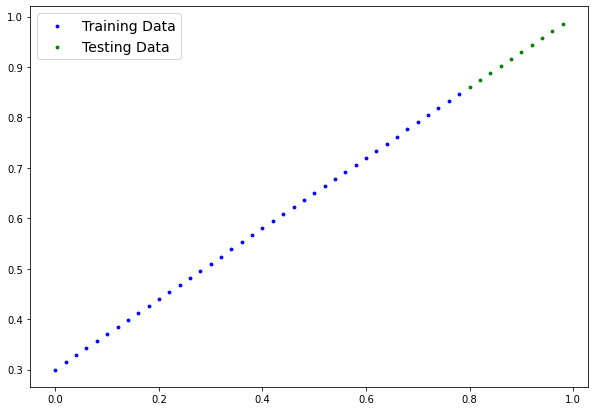

In [5]:
plot_predictions()

## 2.0 Build Model

In [6]:
# create a linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everything in pytorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(
        1, # <- start with random weights (this will get adjysted as the model learns)
        dtype=torch.float), # <- Pytorch loves float32 by default
        requires_grad=True) # <- can we update this value with gradient descent?
    self.bias = nn.Parameter(torch.randn(
        1, # <- start with random bias  (this will get adjusted as the model learns)
        dtype=torch.float), # <- PyTorch loves float32
        requires_grad=True) # <- can we update this value with gradient descent?

  # Forward defines the computatin in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g training/testing features)
    return self.weights*x + self.bias # this is the linear regression formula (y = m*x + b)



## 2.1 Checking the contents of the Model

In [7]:
# set manual seed since nn.Parameter is randomly initialized
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# check the nn.Parameter(s) within the nn.Module subclass
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## 2.2 Passing data through the model (Making Predictions)

In [9]:
# make prdictions with the model
with torch.inference_mode():
  y_preds = model_0(X_test)

#### **Note:** Older PyTorch code might use `torch.no_grad()`
```code
with torch.no_grad():
  y_preds = model_0(X_test)
```

`torch.inference_mode()` is `torch.no_grad()` on steroids.

In [10]:
# checking predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predicitons made: {len(y_preds)}")
print(f"Prediction values: \n{y_preds}")

Number of testing samples: 10
Number of predicitons made: 10
Prediction values: 
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


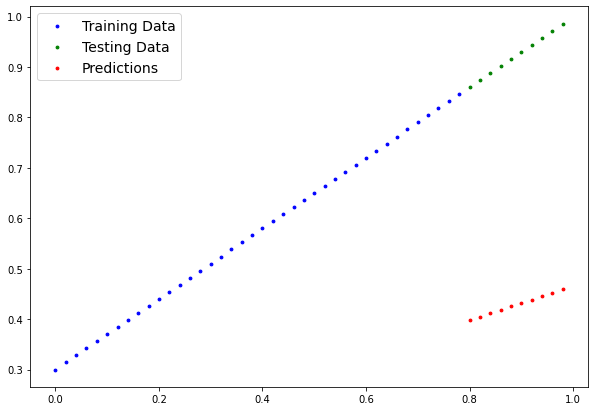

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
# calculate error
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3.0 Train Model

In [13]:
# create loss function
loss_fn = nn.L1Loss() # MAE loss is the same as L1Loss

# create the optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(), # parameters of the target model to optimize
    lr=0.01 # learning rate (how much the optimizer should change parameters at each step, higher = more (less stable), lower = less (might take a long time))
)

In [14]:
torch.manual_seed(42)

# set the number of epochs (how many times the model will pass over the training data)
EPOCHS = 100

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(EPOCHS):
  ### Training

  # put the model in training mode (this is the default state of a model)
  model_0.train()

  # 1. Forward pass on the train data using forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our models predictions from the actual value)
  loss = loss_fn(y_pred, y_train)

  # 3.  Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss Backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Pu the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass on the test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predicitions come in torch.float datatype, so comparison need to be done with tensors of the same datatype

    # Print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
      

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


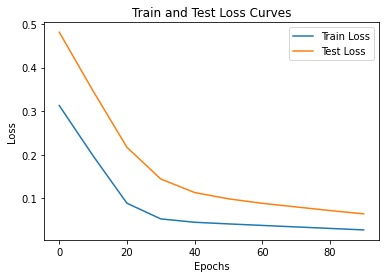

In [15]:
# Plot loss curves
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:\n")
print(model_0.state_dict())
print("\nAnd the original values for weight and bias are:")
print(f"weight: {weight}, bias: {bias}")

The model learned the following values for weights and bias:

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weight and bias are:
weight: 0.7, bias: 0.3


## 4.0 Making predictions with the trained PyTorch model (Inference)

Make sure calculations are done with the model and data on the same device. In our case, we haven't setup device-agnostic code yet so the data and model are on the CPU by default.
```code
model_0.to(device)
X_test = X_test.to(device)
  ```

In [17]:
# 1. set the model to evaluation mode
model_0.eval()

# setup the inference context manager
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

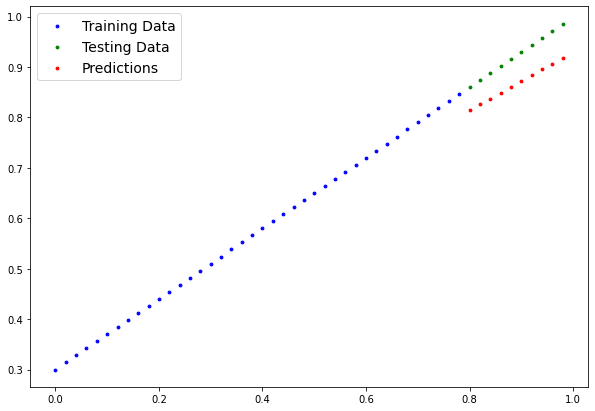

In [18]:
plot_predictions(predictions=y_preds)

## 5.0 Saving and Loading PyTorch Model

In [19]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_0.state_dict(), # only saving the state dict )
    f=MODEL_SAVE_PATH
)


Saving model to: models/01_pytorch_workflow_model_0.pth


In [20]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Feb 22 16:08 models/01_pytorch_workflow_model_0.pth


In [21]:
# Instantiate a new instance of the LinearRegressionModel (This will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state dict of the saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predctions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the model with the test data

In [23]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6.0 Putting it all together

In [24]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu116'

In [25]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 6.1 Data

In [26]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueezing, errors will happen later on (shapes within layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[: train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

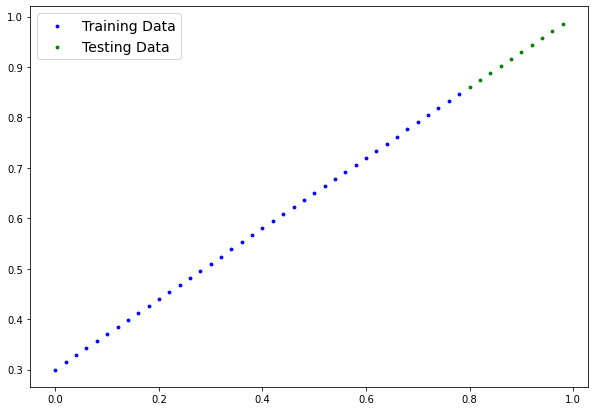

In [28]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building PyTorch Linear Model

In [29]:
# Subclass nn.Module to make our model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  # Define the forward computation (input data x flows through nn.Linear())
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

#  Set the manual seed when creating the model (this isn't needed)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [30]:
# check model device
next(model_1.parameters()).device

device(type='cpu')

In [31]:
# Set model device to GPU if it's available else CPU
model_1.to(device) # device variable was set above to be "cuda" if it is available else "cpu"
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

In [32]:
# create loss function
loss_fn = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(), # optimize newly created model's parameters
    lr=0.01
)

In [33]:
torch.manual_seed(42)

# set the number of epochs
EPOCHS = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Put data on the available device
# Without this, error will happen ( i.e all model/data not on the same device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
  ### Training
  model_1.train() # train mode is on by default after construction

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the Loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss Backward (Back Propagation)
  loss.backward()

  # Optimizer Step (Gradient Descent)
  optimizer.step()

  ### Testing
  model_1.eval() # put the model in evaluation mode for testing (inference)

  # 1. Forward Pass
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())
    print(f"Epoch: {epoch} | Train loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882


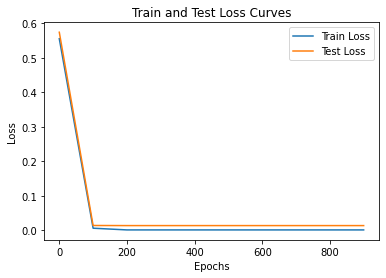

In [34]:
# Plot loss curves
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [36]:
# Find our model's learned parameters
from pprint import pprint 
print("The model learned the following values for weights and bias:\n")
pprint(model_1.state_dict())
print("\nAnd the original values for weight and bias are:\n")
print(f"weight: {weight}, bias: {bias}")

The model learned the following values for weights and bias:

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weight and bias are:

weight: 0.7, bias: 0.3


## 6.4 Make Predictions

In [37]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the rest of the data
with torch.inference_mode():
  y_preds = model_1(X_test)

  # test_loss = loss_fn(y_preds, y_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

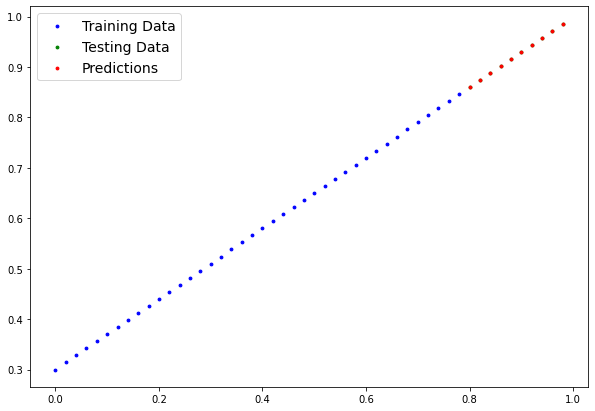

In [40]:
plot_predictions(predictions=y_preds.cpu())

## 6.5 Saving and Loading the Model

In [41]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH  = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_worklflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(
    obj=model_1.state_dict(),
    f=MODEL_SAVE_PATH
)

Saving model to : models/01_pytorch_worklflow_model_1.pth


In [42]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# load mode state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [44]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')